In [1]:
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

In [4]:
cd /content/drive/MyDrive/DATA/Hand

/content/drive/MyDrive/DATA/Hand


In [2]:
from scipy import ndimage as nd
 
from matplotlib import pyplot as plt
from skimage.io import imread, imshow
from skimage.filters import roberts, sobel, scharr, prewitt

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import glob
import cv2
import pickle

from keras.models import Sequential, Model
from keras.layers import Conv2D
import os
from keras.applications.vgg16 import VGG16

In [5]:
source_paths1 = "S1Hand/"
source_paths2 = "S2Hand"
label_path = "LabelHand/"

sources1 = []
sources2 =[]
label = []

for file in os.listdir(source_paths1):
    if file.endswith("tif"):
      sources1.append(file)

for file in os.listdir(source_paths2):
    if file.endswith("tif"):
      sources2.append(file)
        
for file in os.listdir(label_path):
    if file.endswith("tif"):
      label.append(file)


## Sanity Check
sources1 = sorted(sources1)
sources2 = sorted(sources2)
label = sorted(label)
print(len(sources1))
print(len(sources2))
print(len(label))

577
577
577


In [6]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

X_source = np.zeros((len(sources1), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_label = np.zeros((len(sources1),IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.int8)

# Sanity Check
print(X_source.shape)
print(Y_label.shape)

(577, 128, 128, 3)
(577, 128, 128, 1)


In [7]:
for count, file in enumerate(sources1):
    source_img = imread(source_paths1 +'/' +file )[1:2,:,:] # Load only VH band
    s1_image = np.transpose(source_img, (1, 2, 0))

    name = file.split("_")
    s2_name = name[0] + "_" +  name[1] + "_" + "S2Hand_" + name[3]
    s2_image =imread(source_paths2+'/' +s2_name)[[2,3],:,:] # Load only Red and Nir bands
    s2_image = np.transpose(s2_image, (1, 2, 0))

    merged = np.concatenate((s2_image, s1_image), axis=2)
    X_source[count] = merged


for count, file in enumerate(label):
    slabel_img = imread(label_path + '/'+file ) #[:,:,:,IMG_CHANNELS]
    # print(slabel_img.min())
    y = np.expand_dims(slabel_img, axis=2)
    Y_label[count] = y 

In [ ]:
#Use customary x_train and y_train variables
X_train = X_source
Y_train = Y_label
print(X_train.shape)
print(Y_train.shape)

(577, 128, 128, 3)
(577, 128, 128, 1)


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3, random_state=42)

In [ ]:
#Load VGG16 model wothout classifier/fully connected layers
#Load imagenet weights that we are going to use as feature generators
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
    layer.trainable = False
    
VGG_model.summary()  #Trainable parameters will be 0

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

In [ ]:
#After the first 2 convolutional layers the image dimension changes. 
#So for easy comparison to Y (labels) let us only take first 2 conv layers
#and create a new model to extract features
#New model with only first 2 conv layers
new_model = Model(inputs=VGG_model.input, outputs=VGG_model.get_layer('block1_conv2').output)
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
Total params: 38,720
Trainable params: 0
Non-trainable params: 38,720
_________________________________________________________________


In [ ]:
# Αpply feature extractor to our training data
features=new_model.predict(x_train)

13/13 [==============================] - 12s 922ms/step


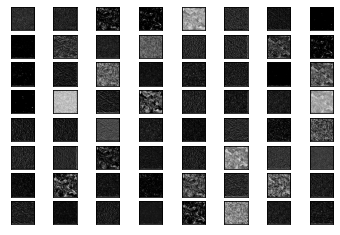

In [ ]:
#Plot features to view them
square = 8
ix=1
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(features[0,:,:,ix-1], cmap='gray')
        ix +=1
plt.show()

In [ ]:
#Reassign 'features' as X to make it easy to follow
X=features
X = X.reshape(-1, X.shape[3])  #Make it compatible for Random Forest and match Y labels

In [ ]:
#Reshape Y to match X
Y = y_train.reshape(-1)

In [ ]:
#Combine X and Y into a dataframe 
#In our labels Y values -1 indicates clouds.
dataset = pd.DataFrame(X)
dataset['Label'] = Y
print(dataset['Label'].unique())
print(dataset['Label'].value_counts())

[ 1  0 -1]
 0    3853859
 1    1981231
-1     767662
Name: Label, dtype: int64


In [ ]:
#Redefine X and Y for Random Forest
X_for_RF = dataset.drop(labels = ['Label'], axis=1)
Y_for_RF = dataset['Label']

In [ ]:
#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 20, verbose=10)

# Train the model on training data
model.fit(X_for_RF, Y_for_RF) 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 20


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.9min remaining:    0.0s


building tree 2 of 20


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.8min remaining:    0.0s


building tree 3 of 20


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  8.8min remaining:    0.0s


building tree 4 of 20


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 11.8min remaining:    0.0s


building tree 5 of 20


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 15.0min remaining:    0.0s


building tree 6 of 20


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 17.8min remaining:    0.0s


building tree 7 of 20


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 20.9min remaining:    0.0s


building tree 8 of 20


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 23.9min remaining:    0.0s


building tree 9 of 20


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 26.8min remaining:    0.0s


building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 55.1min finished


RandomForestClassifier(n_estimators=20, verbose=10)

In [8]:
#Save model for future use
filename = 'TL_model_multimodal.sav'
pickle.dump(model, open(filename, 'wb'))

#Load model.... 
# loaded_model = pickle.load(open(filename, 'rb'))

## TEST THE MODEL

In [ ]:
# x_train, x_test, y_train, y_test
#Now, let us apply feature extractor to our training data
features=new_model.predict(x_test)

6/6 [==============================] - 6s 868ms/step


In [ ]:
#Reassign 'features' as X to make it easy to follow
Xtest=features
Xtest = Xtest.reshape(-1, Xtest.shape[3])  #Make it compatible for Random Forest and match Y labels

In [ ]:
#Reshape Y to match X
# Ytest = y_test.reshape(-1)
Ytest = y_test.reshape(-1)

In [ ]:
#Combine X and Y into a dataframe 
#In our labels Y values -1 indicates clouds.
dataset_test = pd.DataFrame(Xtest)
dataset_test['Label'] = Ytest
print(dataset_test['Label'].unique())
print(dataset_test['Label'].value_counts())

[ 1  0 -1]
 0    1671750
 1     903619
-1     275447
Name: Label, dtype: int64


In [ ]:
#Redefine X and Y for Random Forest
Xtest_for_RF = dataset_test.drop(labels = ['Label'], axis=1)
Ytest_for_RF = dataset_test['Label']

In [ ]:
from sklearn import metrics
prediction_test = model.predict(Xtest_for_RF)
##Check accuracy on test dataset. 
print ("Accuracy = ", metrics.accuracy_score(Ytest_for_RF, prediction_test))
print("IOU = ", metrics.jaccard_score(Ytest_for_RF, prediction_test, average ="micro"))
print("Precision = ", metrics.precision_score(Ytest_for_RF, prediction_test, average ="micro"))
print("Recall = ", 	metrics.recall_score(Ytest_for_RF, prediction_test, average ="micro"))
print("F1 score = ", metrics.f1_score(Ytest_for_RF, prediction_test, average ="micro"))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   16.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   20.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   24.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   27.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   32.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   36.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.2min finished


Accuracy =  0.7181371930001796
IOU =  0.56022937016245
Precision =  0.7181371930001796
Recall =  0.7181371930001796
F1 score =  0.7181371930001796
